# Matérn kernel on Hyperbolic 

This notebooks illustrates Matérn kernel on a Hyperbolic space.

We use numpy for the computations and matplotlib for vizualization.

In [1]:
# !pip install backends==1.4.32 plum-dispatch==1.7.4  # temporary measure

In [2]:
import geomstats.visualization as visualization
import matplotlib.pyplot as plt
import numpy as np

INFO: Using numpy backend


We employ the kernel defined by the _random phase features_. The mathematical details can be found in [1]. For the purposes of this notebook, it suffices to say that on noncompact symmetric spaces (of which the Hyperbolic space is a fine specimen), the kernel is defined in terms of an intractable integral, which we approximate via importance sampling. This is in contrast with _compact_ spaces (which we call `DiscreteSpectrumSpace`s) where the kernel is a sum of a _series_, approximatable via trunkation.

For the practical purposes, we just have to define a number of _random phases_ (the more the better the approximation is and the more computation is required), specify a feature map and pass it to the `MaternFeatureMapKernel`. The kernel requires a `key` to instantiate randomness in _random phases_, and is a **deterministic** function.

In [3]:
from geometric_kernels.kernels.geometric_kernels import MaternFeatureMapKernel
from geometric_kernels.kernels.feature_maps import random_phase_feature_map
from geometric_kernels.spaces.hyperbolic import Hyperbolic

## Instantiate space and kernel



In the numpy world, the `key` is the `np.random.RandomState`:

In [4]:
_num_random_phases = 3_000  # This is the default value, we just state it for completeness

In [5]:
key = np.random.RandomState(seed=1234)  #

In [6]:
hyperboloid = Hyperbolic(dim=2)
feature_map = random_phase_feature_map(hyperboloid, num_random_phases=_num_random_phases)
kernel = MaternFeatureMapKernel(hyperboloid, feature_map, key)

params, state = kernel.init_params_and_state()
params["nu"] = np.inf
params["lengthscale"] = 1.0

## Plot kernel values on a "grid"

We construct a quasi-grid in the Hyperbolic space. Since `Hyperbolic` inherits from `geomstats` [Hyperbolic](https://geomstats.github.io/geometry.html#module-geomstats.geometry.hyperbolic), we exploit this:

In [7]:
s = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(s, s)
points = np.c_[xx.ravel(), yy.ravel()]
points = hyperboloid.from_coordinates(points, "intrinsic")

In [8]:
base_point = hyperboloid.from_coordinates(np.r_[0, 0], "intrinsic").reshape(1, 3)

Again, we use `geomstats` vizualization module to plot data on a Hyperbolic disk.

In [9]:
kernel_vals = kernel.K(params, state, base_point, points)

<Axes: xlabel='X', ylabel='Y'>

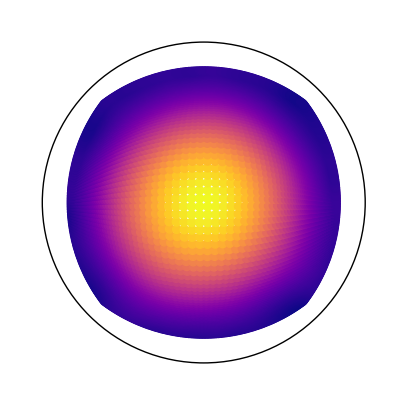

In [10]:
plt.figure(figsize=(5,5))
visualization.plot(points, space="H2_poincare_disk", c=kernel_vals, cmap="plasma")

We can also visualize as a hyperboloid. We transpose some coordinates to get a better view:

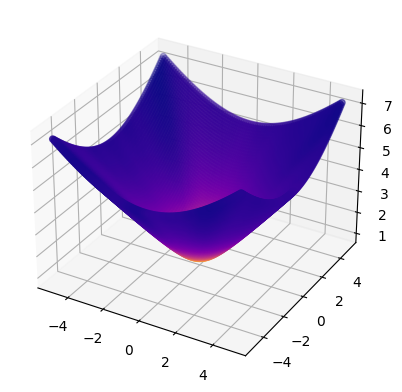

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = kernel_vals[0]
ax.scatter(points[:, 2], points[:, 1], points[:, 0], c=colors, cmap='plasma')

## Plot kernel values along a geodesic

Let's plot kernel values `K(x, y)` where `y` runs the geodesic between `base` and `end_point`.

In [12]:
base = np.r_[7.14142843, -5.0, -5.0]
end_point = np.r_[14.17744688, 10.0, 10.0]

geodesic = hyperboloid.metric.geodesic(initial_point=base, end_point=end_point)
x1 = geodesic(np.linspace(0.0, 1.0, 30))
x2 = x1[0, None]

distances = hyperboloid.distance(x1, x2)

In [13]:
kernel_vals = kernel.K(params, state, x1, x2)

Text(0, 0.5, 'K')

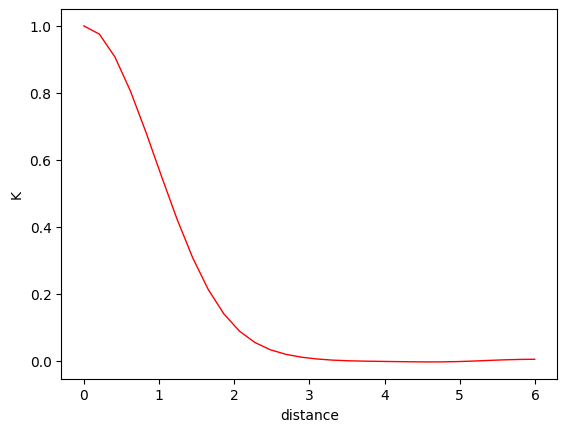

In [14]:
plt.plot(distances, kernel_vals, color="red", linewidth=1)
plt.xlabel('distance')
plt.ylabel('K')